In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [3]:
import pandas as pd

fake_news = pd.read_csv("fake.csv")
real_news = pd.read_csv("real_news.csv")

# Select relevant columns and label
real_news2 = real_news[['title', 'content', 'publication']]
real_news2['label'] = 1  # Change 'real' to 1

fake_news2 = fake_news[['title', 'text', 'site_url']]
fake_news2['label'] = 0  # Change 'fake' to 0

# Process site URLs
site_urls = fake_news2['site_url']
site_urls2 = [x.split('.', 1)[0] for x in site_urls]
fake_news2['site_url'] = site_urls2

# Rename columns
new_labels = ['title', 'content', 'publication', 'label']
real_news2.columns = new_labels
fake_news2.columns = new_labels

# Concatenate dataframes
frames = [fake_news2, real_news2]
news_dataset = pd.concat(frames)

# Check for missing values
print(news_dataset.isnull().sum())

# Drop rows with missing values
news_dataset = news_dataset.dropna()

# Save to CSV
news_dataset.to_csv('news_dataset.csv', encoding='utf-8', index=False)



C:\Users\anagh\AppData\Local\Temp\ipykernel_17892\3399723658.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_news2['label'] = 1  # Change 'real' to 1
C:\Users\anagh\AppData\Local\Temp\ipykernel_17892\3399723658.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news2['label'] = 0  # Change 'fake' to 0
C:\Users\anagh\AppData\Local\Temp\ipykernel_17892\3399723658.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

title          680
content         46
publication      0
label            0
dtype: int64


In [4]:
def clean_text(text):
    # Example: remove special characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

news_dataset['title'] = news_dataset['title'].apply(clean_text)
news_dataset['content'] = news_dataset['content'].apply(clean_text)

In [5]:
def whitespace_tokenize(text):
    return text.split()

# Apply the custom tokenizer to the 'title' and 'content' columns
news_dataset['title_tokens'] = news_dataset['title'].apply(whitespace_tokenize)
news_dataset['content_tokens'] = news_dataset['content'].apply(whitespace_tokenize)


In [6]:
stop_words = set(stopwords.words('english'))

news_dataset['title_tokens'] = news_dataset['title_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
news_dataset['content_tokens'] = news_dataset['content_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Combine 'title' and 'content' for fitting the vectorizer
combined_text = news_dataset['title'] + ' ' + news_dataset['content']
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_text)

# Transform 'title' and 'content' separately
title_tfidf = tfidf_matrix[:, :len(news_dataset['title_tokens'])]
content_tfidf = tfidf_matrix[:, len(news_dataset['title_tokens']):]


In [8]:
news_dataset.to_csv('final_dataset.csv', encoding='utf-8', index=False)

In [9]:
preprocessed_data = pd.read_csv('final_dataset.csv')

In [10]:
X = preprocessed_data['content_tokens'].apply(lambda x: ' '.join(eval(x)))  # Convert list to string
y = preprocessed_data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# GRADIENT BOOSTING CLASSIFIER

In [12]:
# Initialize and train the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test_tfidf)
y_train_pred=gb_classifier.predict(X_train_tfidf)

In [13]:
# Evaluate the model on the train set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.2f}")   

Train Accuracy: 0.90


In [15]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f"F1 Score: {f1}")

Accuracy: 0.8930
Precision: 0.8844
Recall: 0.8727
F1 Score: 0.8929022185864292


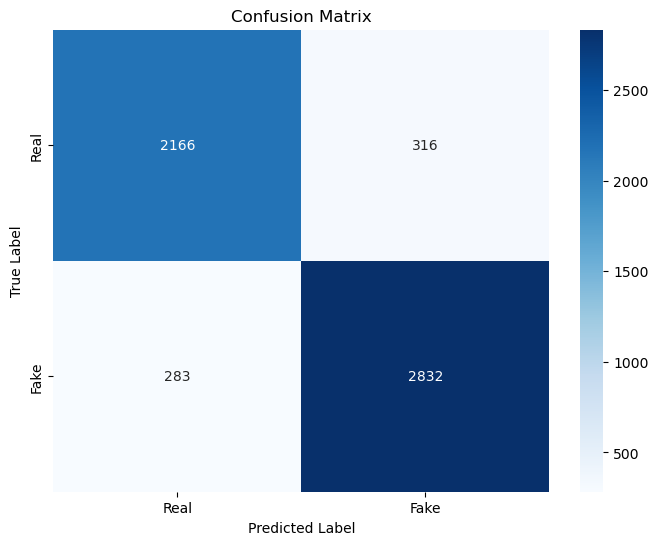

In [16]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# SVM

In [17]:
# Initialize and train the SVM model
svm_classifier = SVC(kernel='linear', random_state=42)  # Use a linear kernel for text data
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)
y_train_pred=svm_classifier.predict(X_train_tfidf)

In [18]:
# Evaluate the model on the train set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.2f}") 

Train Accuracy: 0.96


In [19]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f"F1 Score: {f1}")

Accuracy: 0.9226
Precision: 0.9143
Recall: 0.9110
F1 Score: 0.9226226675920383


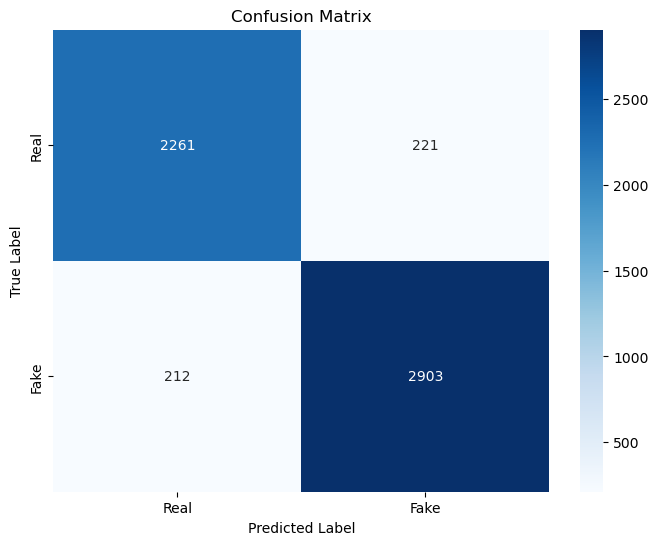

In [20]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# NAIVE BAYES

In [21]:
# Initialize and train the Naive Bayes model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_tfidf)
y_train_pred=nb_classifier.predict(X_train_tfidf)

In [22]:
# Evaluate the model on the train set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.2f}")  

Train Accuracy: 0.84


In [23]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f"F1 Score: {f1}")

Accuracy: 0.8312
Precision: 0.8630
Recall: 0.7361
F1 Score: 0.8291317657312085


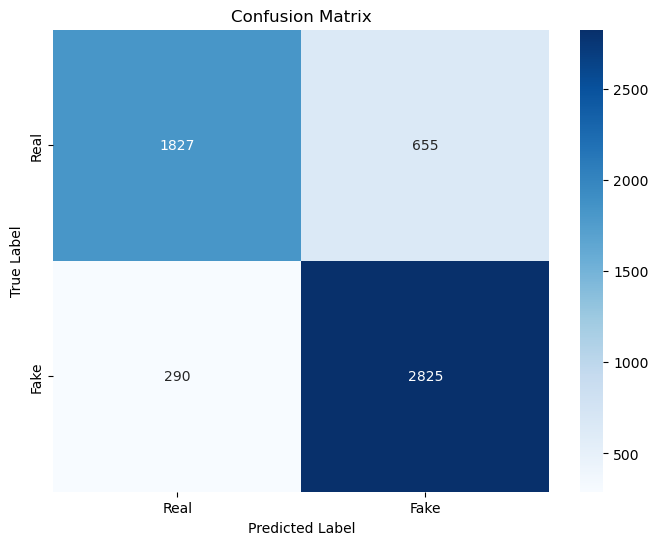

In [24]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# RANDOM FOREST CLASSIFIER

In [25]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=0)

In [26]:
pred_rfc = RFC.predict(X_test_tfidf)
y_train_pred=RFC.predict(X_train_tfidf)

In [27]:
RFC.score(X_train_tfidf, y_train)

0.9999106664284438

In [28]:
# Evaluate the model on the train set
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.2f}")  

Train Accuracy: 1.00


In [29]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f"F1 Score: {f1}")

Accuracy: 0.8312
Precision: 0.8630
Recall: 0.7361
F1 Score: 0.8291317657312085


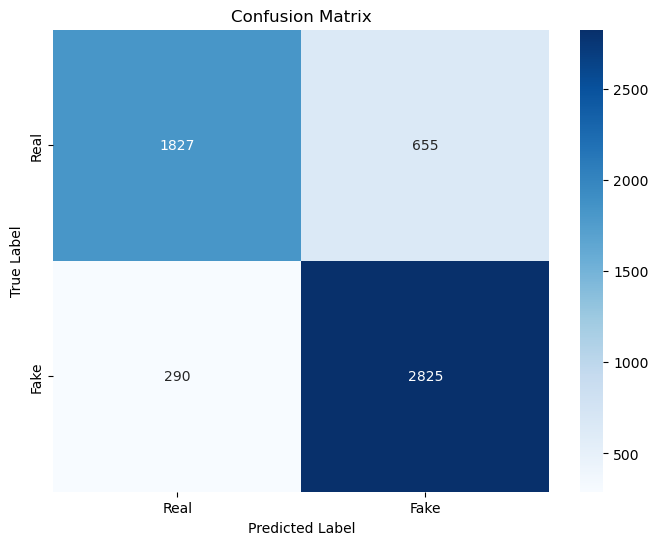

In [30]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC CURVE

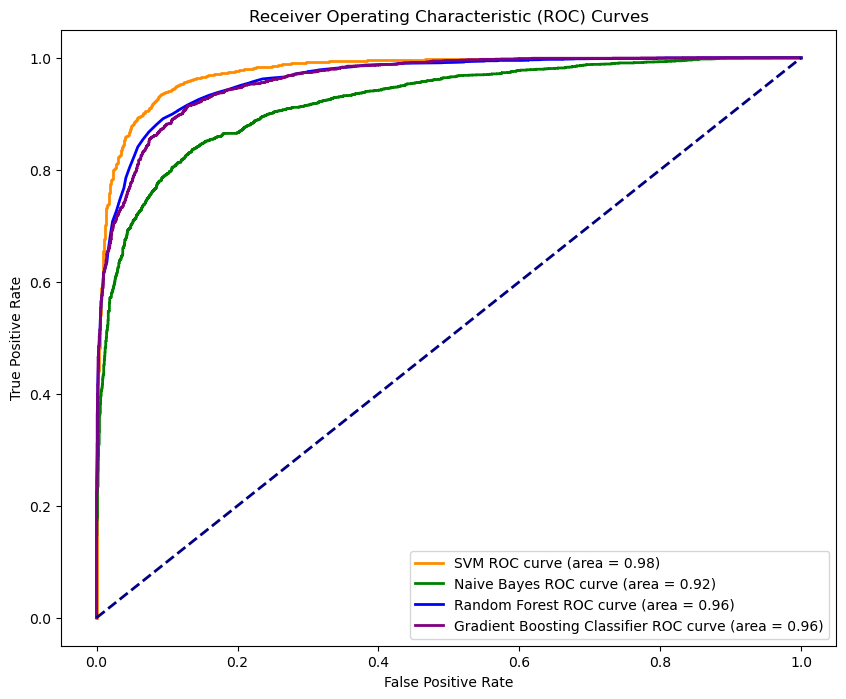

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Get predicted probabilities for the positive class
y_pred_prob_svm = svm_classifier.decision_function(X_test_tfidf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Get predicted probabilities for the positive class
y_pred_prob_nb = nb_classifier.predict_proba(X_test_tfidf)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Get predicted probabilities for the positive class
y_pred_prob_rfc = RFC.predict_proba(X_test_tfidf)[:, 1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_pred_prob_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# Get predicted probabilities for the positive class
y_pred_prob_gbc = gb_classifier.predict_proba(X_test_tfidf)[:, 1]
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

# Plot ROC curves in a single graph
plt.figure(figsize=(10, 8))

plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM ROC curve (area = {roc_auc_svm:.2f})')
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label=f'Naive Bayes ROC curve (area = {roc_auc_nb:.2f})')
plt.plot(fpr_rfc, tpr_rfc, color='blue', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rfc:.2f})')
plt.plot(fpr_gbc, tpr_gbc, color='purple', lw=2, label=f'Gradient Boosting Classifier ROC curve (area = {roc_auc_gbc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()
